In [1]:
import jax
import jax.numpy as jnp
import numpy as np # get rid of this eventually
import argparse
from jax import jit
from jax.experimental.ode import odeint
from functools import partial # reduces arguments to function by making some subset implicit

from jax.example_libraries import stax
from jax.experimental import optimizers

import os, sys, time
sys.path.append('..')

In [2]:
sys.path.append('../experiment_dblpend/')

from lnn import lagrangian_eom_rk4, lagrangian_eom, unconstrained_eom, raw_lagrangian_eom
from data import get_dataset
from models import mlp as make_mlp
from utils import wrap_coords

In [3]:
sys.path.append('../hyperopt')

In [4]:
from HyperparameterSearch import learned_dynamics

In [5]:
from HyperparameterSearch import extended_mlp

In [6]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

In [7]:
from data import get_trajectory

In [8]:
from data import get_trajectory_analytic

In [9]:
from physics import analytical_fn

vfnc = jax.jit(jax.vmap(analytical_fn))
vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))

In [10]:
# 0.29830917716026306 {'act': [4],
# 'batch_size': [27.0], 'dt': [0.09609870774790222],
# 'hidden_dim': [596.0], 'l2reg': [0.24927677946969878],
# 'layers': [4.0], 'lr': [0.005516656601005163],
# 'lr2': [1.897157209816416e-05], 'n_updates': [4.0]}

### Now, let's load the best model. To generate more models, see the code below.

In [11]:
import pickle as pkl

In [12]:
# loaded = pkl.load(open('./params_for_loss_0.29429444670677185_nupdates=1.pkl', 'rb'))

In [13]:
args = ObjectView({'dataset_size': 200,
 'fps': 10,
 'samples': 100,
 'num_epochs': 80000,
 'seed': 0,
 'loss': 'l1',
 'act': 'relu_relu',
 'hidden_dim': 600,
 'output_dim': 2,
 'layers': 3,
 'n_updates': 1,
 'lr': 0.001,
 'lr2': 2e-05,
 'dt': 0.1,
 'model': 'gln',
 'batch_size': 512,
 'l2reg': 5.7e-07,
})
# args = loaded['args']
rng = jax.random.PRNGKey(args.seed)

In [14]:
from jax.experimental.ode import odeint

In [15]:
from HyperparameterSearch import new_get_dataset

In [16]:
from matplotlib import pyplot as plt

In [17]:
vfnc = jax.jit(jax.vmap(analytical_fn, 0, 0))
vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))
minibatch_per = 2000
batch = 512

@jax.jit
def get_derivative_dataset(rng):
    # randomly sample inputs

    y0 = jnp.concatenate([
        jax.random.uniform(rng, (batch*minibatch_per, 2))*2.0*np.pi,
        (jax.random.uniform(rng+1, (batch*minibatch_per, 2))-0.5)*10*2
    ], axis=1)
    
    return y0, vfnc(y0)

In [18]:
best_params = None
best_loss = np.inf

In [19]:
from itertools import product

In [20]:
# @jax.jit
def baseline_eom(baseline, state, t=None):
    q, q_t = jnp.split(state, 2)
    q = q % (2*jnp.pi)
    q_tt = baseline(q, q_t)
    return jnp.concatenate([q_t, q_tt])


In [21]:
init_random_params, nn_forward_fn = extended_mlp(args)
import HyperparameterSearch
HyperparameterSearch.nn_forward_fn = nn_forward_fn
_, init_params = init_random_params(rng+1, (-1, 4))
rng += 1
model = (nn_forward_fn, init_params)
opt_init, opt_update, get_params = optimizers.adam(args.lr)
opt_state = opt_init([[l2/200.0 for l2 in l1] for l1 in init_params])
from jax.tree_util import tree_flatten
from HyperparameterSearch import make_loss, train
from copy import deepcopy as copy
# train(args, model, data, rng);
from jax.tree_util import tree_flatten

@jax.jit
def loss(params, batch, l2reg):
    state, targets = batch#_rk4
    leaves, _ = tree_flatten(params)
    l2_norm = sum(jnp.vdot(param, param) for param in leaves)
    preds = jax.vmap(
        partial(
            baseline_eom,
            learned_dynamics(params)))(state)
    return jnp.sum(jnp.abs(preds - targets)) + l2reg*l2_norm/args.batch_size

# @jax.jit
# def normalize_param_update(param_update):
#     new_params = []
#     num_weights = args.hidden_dim**2*3
#     gradient_norm = sum([jnp.sum(l2**2)
#                          for l1 in param_update
#                          for l2 in l1
#                          if len(l1) != 0])/num_weights
# #     gradient_norm = 1 + 
#     for l1 in param_update:
#         if (len(l1)) == 0: new_params.append(()); continue
#         new_l1 = []
#         for l2 in l1:
#             new_l1.append(
#                 l2/gradient_norm
#             )

#         new_params.append(new_l1)
        
#     return new_params

@jax.jit
def update_derivative(i, opt_state, batch, l2reg):
    params = get_params(opt_state)
    param_update = jax.grad(
            lambda *args: loss(*args)/len(batch),
            0
        )(params, batch, l2reg)
#     param_update = normalize_param_update(param_update)
    params = get_params(opt_state)
    return opt_update(i, param_update, opt_state), params


best_small_loss = np.inf
(nn_forward_fn, init_params) = model
iteration = 0
total_epochs = 300
minibatch_per = 2000
train_losses, test_losses = [], []

lr = 4e-5 #1e-3
import math

final_div_factor=1e4

#OneCycleLR:
@jax.jit
def OneCycleLR(pct):
    #Rush it:
    start = 0.2 #0.2
    pct = pct * (1-start) + start
    high, low = lr, lr/final_div_factor
    
    scale = 1.0 - (jnp.cos(2 * jnp.pi * pct) + 1)/2
    
    return low + (high - low)*scale
    
from lnn import custom_init

opt_init, opt_update, get_params = optimizers.adam(
    OneCycleLR
)

# init_params = custom_init(init_params, seed=0)
# init_params = 
opt_state = opt_init(init_params)
# opt_state = opt_init(best_params)
bad_iterations = 0
print(lr)

4e-05


Idea: add identity before inverse:

# Let's train it:

In [22]:
rng = jax.random.PRNGKey(0)

In [23]:
epoch = 0

In [24]:
batch_data = get_derivative_dataset(rng)[0][:10], get_derivative_dataset(rng)[1][:10]
print(batch_data[0].shape)

(10, 4)


In [25]:
loss(get_params(opt_state), batch_data, 0.0)

DeviceArray(329.27036, dtype=float32)

In [26]:
opt_state, params = update_derivative(0.0, opt_state, batch_data, 0.0)

In [27]:
from tqdm.notebook import tqdm

In [28]:
# best_loss = np.inf
# best_params = None

In [64]:
for epoch in tqdm(range(epoch, total_epochs)):
    epoch_loss = 0.0
    num_samples = 0
    all_batch_data = get_derivative_dataset(rng)
    for minibatch in range(minibatch_per):
        fraction = (epoch + minibatch/minibatch_per)/total_epochs
        batch_data = (all_batch_data[0][minibatch*batch:(minibatch+1)*batch], all_batch_data[1][minibatch*batch:(minibatch+1)*batch])
        rng += 10
        opt_state, params = update_derivative(fraction, opt_state, batch_data, 1e-6)
        cur_loss = loss(params, batch_data, 0.0)
        epoch_loss += cur_loss
        num_samples += batch
    closs = epoch_loss/num_samples
    print('epoch={} lr={} loss={}'.format(
        epoch, OneCycleLR(fraction), closs)
         )
    if closs < best_loss:
        best_loss = closs
        best_params = [[copy(jax.device_get(l2)) for l2 in l1] if len(l1) > 0 else () for l1 in params]

epoch=0 lr=1.414164034940768e-05 loss=0.08233094215393066
epoch=1 lr=1.4462808394455351e-05 loss=0.08085848391056061
epoch=2 lr=1.478552985645365e-05 loss=0.08081990480422974
epoch=3 lr=1.5109715604921803e-05 loss=0.08108066767454147
epoch=4 lr=1.5435276509379037e-05 loss=0.08120445907115936
epoch=5 lr=1.5762116163386963e-05 loss=0.08121983706951141
epoch=6 lr=1.609015089343302e-05 loss=0.08122540265321732
epoch=7 lr=1.641928065510001e-05 loss=0.08126170188188553
epoch=8 lr=1.6749418136896566e-05 loss=0.08138350397348404
epoch=9 lr=1.70804687513737e-05 loss=0.0815456435084343
epoch=10 lr=1.741233791108243e-05 loss=0.08131673187017441
epoch=11 lr=1.774493466655258e-05 loss=0.08151450008153915
epoch=12 lr=1.807816261134576e-05 loss=0.08159146457910538
epoch=13 lr=1.84119344339706e-05 loss=0.08152744919061661
epoch=14 lr=1.8746148271020502e-05 loss=0.08140755444765091
epoch=15 lr=1.90807186299935e-05 loss=0.08162107318639755
epoch=16 lr=1.94155472854618e-05 loss=0.08152826130390167
epoch=

Look at distribution of weights to make a better model?

In [29]:
best_params = pkl.load(
    open('best_dblpendulum_baseline_v5_900epoch.pt', 'rb')
)

In [30]:
# p = get_params(opt_state)

In [31]:
opt_state = opt_init(best_params)

In [32]:
# pkl.dump(
#     best_params,
#     open('best_dblpendulum_baseline_v5_900epoch.pt', 'wb')
# )

### Make sure the args are the same:

In [33]:
# opt_state = opt_init(loaded['params'])

In [34]:
rng+7

DeviceArray([7, 7], dtype=uint32)

The seed: [8, 8] looks pretty good! Set args.n_updates=3, and the file params_for_loss_0.29429444670677185_nupdates=1.pkl.

In [35]:
plt.rc('font', family='serif')

In [36]:
max_t = 10
new_dataset = new_get_dataset(jax.random.PRNGKey(2),
                              t_span=[0, max_t],
                              fps=10, test_split=1.0,
                              unlimited_steps=False)


In [37]:
t = new_dataset['x'][0, :]
tall = [jax.device_get(t)]
p = get_params(opt_state)

In [38]:
new_dataset['x'].shape

(99, 4)

In [39]:
pred_tall = jax.device_get(odeint(
    partial(baseline_eom, learned_dynamics(p)),
    t,
    np.linspace(0, max_t, num=new_dataset['x'].shape[0])))

In [40]:
@jit
def kinetic_energy(state, m1=1, m2=1, l1=1, l2=1, g=9.8):
    q, q_dot = jnp.split(state, 2)
    (t1, t2), (w1, w2) = q, q_dot

    T1 = 0.5 * m1 * (l1 * w1)**2
    T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 + 2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
    T = T1 + T2
    return T

@jit
def potential_energy(state, m1=1, m2=1, l1=1, l2=1, g=9.8):
    q, q_dot = jnp.split(state, 2)
    (t1, t2), (w1, w2) = q, q_dot

    y1 = -l1 * jnp.cos(t1)
    y2 = y1 - l2 * jnp.cos(t2)
    V = m1 * g * y1 + m2 * g * y2
    return V

Text(0.5, 0, 'Time')

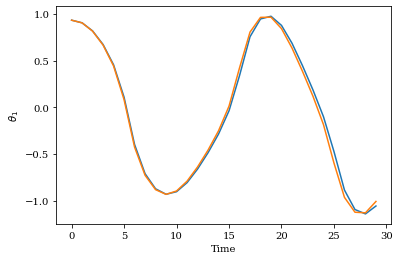

In [41]:
tall = np.array(tall)
plt.plot(new_dataset['x'][:30, 0])#[:100, 0])
plt.plot(pred_tall[:30, 0])

plt.ylabel(r'$\theta_1$')
plt.xlabel('Time')

In [ ]:
all_errors = []
for i in tqdm(range(100)):
    max_t = 100
    new_dataset = new_get_dataset(jax.random.PRNGKey(i),
                                  t_span=[0, max_t],
                                  fps=10, test_split=1.0,
                                  unlimited_steps=False)
    t = new_dataset['x'][0, :]
    tall = [jax.device_get(t)]
    p = best_params
    pred_tall = jax.device_get(odeint(
        partial(baseline_eom, learned_dynamics(p)),
        t,
        np.linspace(0, max_t, num=new_dataset['x'].shape[0]),
        mxstep=100))

    total_true_energy = (
        jax.vmap(kinetic_energy, 0, 0)(new_dataset['x'][:]) + \
        jax.vmap(potential_energy, 0, 0)(new_dataset['x'][:])
    )
    total_predicted_energy = (
        jax.vmap(kinetic_energy, 0, 0)(pred_tall[:]) + \
        jax.vmap(potential_energy, 0, 0)(pred_tall[:])
    )

    scale=29.4

    # translation = jnp.min(total_true_energy) + 1
    # total_true_energy -= translation
    # total_predicted_energy -= translation

    cur_error = jnp.abs((total_predicted_energy-total_true_energy)[-1])/scale
    all_errors.append(cur_error)
    
    print(i, 'current error', jnp.average(all_errors))

0 current error 0.0038181357
1 current error 0.021209426
2 current error 0.01846676
3 current error 0.047700986
4 current error 0.050402828
5 current error 0.046946183
6 current error 0.044238884
7 current error 0.039473616
8 current error 0.035828345
9 current error 0.032732606
10 current error 0.030316547
11 current error 0.028577417
12 current error 0.028252253
13 current error 0.029273892
14 current error 0.031878117
15 current error 0.029994529
16 current error 0.03498629
17 current error 0.03309936
18 current error 0.03261298
19 current error 0.03116028
20 current error 0.030652355
21 current error 0.029808465
22 current error 0.03206598
23 current error 0.030886434
24 current error 0.02967531
25 current error 0.028906314
26 current error 0.02900661
27 current error 0.028143957
28 current error 0.027396614
29 current error 0.026806256
30 current error 0.026434598
31 current error 0.025650725
32 current error 0.024904592
33 current error 0.02522585
34 current error 0.089925386
35 

# Can't run the 44th system. Just freezes...

## Make plots:

(-0.06, 0.01)

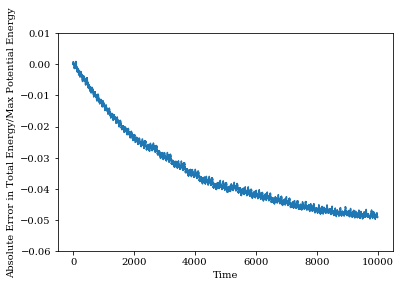

In [74]:
total_true_energy = (
    jax.vmap(kinetic_energy, 0, 0)(new_dataset['x'][:]) + \
    jax.vmap(potential_energy, 0, 0)(new_dataset['x'][:])
)
total_predicted_energy = (
    jax.vmap(kinetic_energy, 0, 0)(pred_tall[:]) + \
    jax.vmap(potential_energy, 0, 0)(pred_tall[:])
)
scale=29.4

# translation = jnp.min(total_true_energy) + 1
# total_true_energy -= translation
# total_predicted_energy -= translation

plt.plot(
    (total_predicted_energy-total_true_energy)/scale
)

plt.ylabel('Absolute Error in Total Energy/Max Potential Energy')
plt.xlabel('Time')
plt.ylim(-0.06, 0.01)

In [75]:
# np.save('baseline_dblpend_energy.npy', total_predicted_energy)
# np.save('baseline_dblpend_prediction.npy', pred_tall)

In [108]:
rng = jax.random.PRNGKey(int(1e9))

In [109]:
batch_data = get_derivative_dataset(rng)[0][:100000], get_derivative_dataset(rng)[1][:100000]
print(batch_data[0].shape)

(100000, 4)


In [110]:
loss(best_params, batch_data, 0.0)/len(batch_data[0])

DeviceArray(0.07387472, dtype=float32)

In [16]:
best_loss = np.inf
best_params = None

In [ ]:
for _i in range(1000):
    print('Running', _i)
    print('Cur best', str(best_loss))

    init_random_params, nn_forward_fn = extended_mlp(args)
    import HyperparameterSearch
    HyperparameterSearch.nn_forward_fn = nn_forward_fn
    _, init_params = init_random_params(rng+1, (-1, 4))
    rng += 1
    model = (nn_forward_fn, init_params)
    opt_init, opt_update, get_params = optimizers.adam(3e-4)##lambda i: jnp.select([i<10000, i>= 10000], [args.lr, args.lr2]))
    opt_state = opt_init(init_params)
    from jax.tree_util import tree_flatten
    from HyperparameterSearch import make_loss, train
    loss = make_loss(args)
    from copy import deepcopy as copy
    train(args, model, data, rng);
    from jax.tree_util import tree_flatten

    @jax.jit
    def update_derivative(i, opt_state, batch, l2reg):
        params = get_params(opt_state)
        param_update = jax.grad(loss, 0)(params, batch, l2reg)
        leaves, _ = tree_flatten(param_update)
        infinities = sum((~jnp.isfinite(param)).sum() for param in leaves)

        def true_fun(x):
            #No introducing NaNs.
            return opt_update(i, param_update, opt_state), params

        def false_fun(x):
            #No introducing NaNs.
            return opt_state, params

        return jax.lax.cond(infinities==0, 0, true_fun, 0, false_fun)


    best_small_loss = np.inf
    (nn_forward_fn, init_params) = model
    data = {k: jax.device_put(v) for k,v in data.items()}
    iteration = 0
    train_losses, test_losses = [], []
    lr = args.lr
    opt_init, opt_update, get_params = optimizers.adam(lr)
    opt_state = opt_init(init_params)
    bad_iterations = 0
    offset = 0
    
    while iteration < 20000:
        iteration += 1
        rand_idx = jax.random.randint(rng, (args.batch_size,), 0, len(data['x']))
        rng += 1

        batch = (data['x'][rand_idx], data['dx'][rand_idx])
        opt_state, params = update_derivative(iteration+offset, opt_state, batch, args.l2reg)
        small_loss = loss(params, batch, 0.0)

        new_small_loss = False
        if small_loss < best_small_loss:

            best_small_loss = small_loss
            new_small_loss = True
        
        if jnp.isnan(small_loss).sum() or new_small_loss or (iteration % 500 == 0) or (iteration < 1000 and iteration % 100 == 0):
            params = get_params(opt_state)
            train_loss = loss(params, (data['x'], data['dx']), 0.0)/len(data['x'])
            train_losses.append(train_loss)
            test_loss = loss(params, (data['test_x'], data['test_dx']), 0.0)/len(data['test_x'])
            test_losses.append(test_loss)
            
            if iteration >= 1000 and test_loss > 1.5:
                #Only good seeds allowed!
                break

            if test_loss < best_loss:
                best_loss = test_loss
                best_params = copy(params)
                bad_iterations = 0
                offset += iteration
                iteration = 0 #Keep going since this one is so good!

            if jnp.isnan(test_loss).sum():
                break
                lr = lr/2
                opt_init, opt_update, get_params = optimizers.adam(lr)
                opt_state = opt_init(best_params)
                bad_iterations = 0

            print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")

        bad_iterations += 1
    
    import pickle as pkl
    if best_loss < np.inf:
        pkl.dump({'params': best_params, 'args': args},
             open('params_for_loss_{}_nupdates=1.pkl'.format(best_loss), 'wb'))

Running 0
Cur best 0.5416298
iteration=1, train_loss=3.281229, test_loss=3.362365
iteration=2, train_loss=3.338815, test_loss=3.414896
iteration=3, train_loss=3.173423, test_loss=3.245358
iteration=5, train_loss=2.876028, test_loss=2.953962
iteration=8, train_loss=2.617690, test_loss=2.711931
iteration=12, train_loss=2.461916, test_loss=2.569056
iteration=14, train_loss=2.420607, test_loss=2.529519
iteration=16, train_loss=2.393510, test_loss=2.502541
iteration=24, train_loss=2.345873, test_loss=2.449337
iteration=69, train_loss=2.283767, test_loss=2.380207
iteration=71, train_loss=2.279208, test_loss=2.375960
iteration=100, train_loss=2.052558, test_loss=2.182241
iteration=126, train_loss=2.150693, test_loss=2.242196
iteration=138, train_loss=2.043466, test_loss=2.179271
iteration=139, train_loss=2.103001, test_loss=2.250430
iteration=159, train_loss=1.884455, test_loss=2.035448
iteration=200, train_loss=2.981948, test_loss=3.082102
iteration=300, train_loss=2.960814, test_loss=3.0604

In [19]:
import importlib

In [22]:
import lnn

In [24]:
importlib.reload(lnn)

<module 'lnn' from '../lnn.py'>

In [25]:
from lnn import lagrangian_eom_rk4

In [236]:
loss(best_params, (data['test_x'], data['test_dx']), 0.0)/len(data['test_x'])

DeviceArray(1.8673568, dtype=float32)

In [ ]:
best_loss